<a href="https://colab.research.google.com/github/yiruchen4/Chen2025/blob/main/Code/ChenFigure3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os
import itertools
from IPython.display import Image
from matplotlib.gridspec import GridSpec
import re, ast
import warnings
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

warnings.filterwarnings("ignore")

In [4]:
# @title Figure 3A
Image(url='https://github.com/yiruchen4/Chen2025/blob/main/Images/Figure%203A.png?raw=true', width=1000)

In [6]:
# @title Figure 3B
Image(url='https://github.com/yiruchen4/Chen2025/blob/main/Images/Figure%203B.png?raw=true', width=1200)

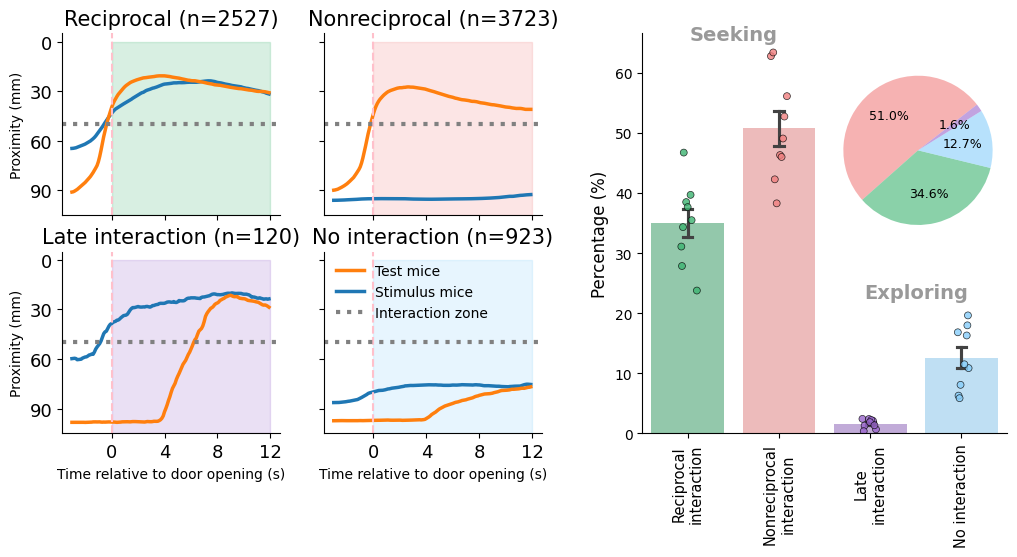

In [9]:
# @title Figure 1C-D
data = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2025/main/Data/all_DOORs_250606.csv")
event_social = data.query('mode == "social"')
def safe_list_parse(df, column):
    """
    Fix a column where lists are stored as strings.
    Handles both comma-separated and space-separated formats.

    Args:
        df: pandas DataFrame
        column: str, name of the column to fix

    Returns:
        df with the specified column parsed into lists of floats
    """
    df[column] = (
        df[column]
        .astype(str)
        .str.strip('[]')
        .apply(lambda s: [float(x) for x in re.split(r'[,\s]+', s.strip()) if x])
    )
    return df

warnings.filterwarnings("ignore")

def approach_time_cluster_plot(event_df, n_Clusters=4, piechartcomponent = 'interaction'):
    event_df = safe_list_parse(event_df, 'time_window')
    event_df = safe_list_parse(event_df, 'event_vector')
    event_df = event_df[(event_df['device_number']!=0)&(event_df['device_number']!=2)&(event_df['device_number']!=3)&(event_df['device_number']!=5)&(event_df['device_number']!=6)&(event_df['device_number']!=8)]
    time_window = np.round(np.arange(-3, 12, 0.1), 2)
    # Apply literal_eval only if the value is a string
    event_df['event_vector'] = event_df['event_vector'].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )

    event_df['time_window'] = event_df['time_window'].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )

    light_colors = {
        2: "#9966CC",  #"Stimulus mice only" Amethyst
        0: "#3CB371",  #"Reciprocal interaction" Medium Sea Green
        3: "#87CEFA",  #"Neither approaching" Sky Blue
        1: "#F08080",  #"Nonreciprocal interaction" Light Coral
        "Unclassified": 'silver'  # Sliver
    }
    cluster_colors = event_df['cluster'].map({i: light_colors[i] for i in event_df['cluster'].unique()})
    if n_Clusters == 2:
        light_colors = ["#9966CC", "#3CB371"]
        cluster_colors = event_df['cluster'].map({i: light_colors[i] for i in event_df['cluster'].unique()})

    # Create a GridSpec layout
    fig = plt.figure(figsize=(15, 8))
    gs = GridSpec(1, 3, figure=fig, width_ratios=[1.2, 1.5, 1],left=0.02, right=0.98,top=1, bottom=0.5)

    ax_bar = fig.add_subplot(gs[0, 2])
    import textwrap

    light_colors_str = {
        "Late interaction": "#9966CC",  # Sky Blue
        "Reciprocal interaction": "#3CB371",  # Medium Sea Green
        "No interaction": "#87CEFA",  # Amethyst
        "Nonreciprocal interaction": "#F08080",  # Light Coral
    }
    interaction_color_map = {interaction: light_colors_str[interaction] for interaction in event_df[piechartcomponent].unique()}
    if n_Clusters == 2 or piechartcomponent == 'behavior':
        piechartcomponent = 'behavior'
        light_colors_str = {
        "Seeking": "#3CB371",  # Medium Sea Green
        "Exploring": "#9966CC",  # Amethyst
        }
        interaction_color_map = {component: light_colors_str[component] for component in event_df[piechartcomponent].unique()}

    general_interaction_counts = event_df[piechartcomponent].value_counts()
    general_interaction_percentages = general_interaction_counts / general_interaction_counts.sum() * 100
    general_labels = general_interaction_percentages.index.tolist()
    wrapped_labels = [textwrap.fill(label, width=15) for label in general_labels]
    colors = [interaction_color_map[label] for label in general_labels]

    def autopct_func(pct, all_counts=None):
        count = int(round(pct / 100. * sum(all_counts))) if all_counts is not None else int(round(pct))
        return f"{pct:.1f}%\n({count})"

    interaction_counts = event_df.groupby(['interaction']).size()
    interaction_percentages = interaction_counts / interaction_counts.sum() * 100

    # Prepare individual data points
    individual_data = event_df.groupby(['device_number', 'interaction']).size().unstack(fill_value=0)
    individual_data = individual_data.div(individual_data.sum(axis=1), axis=0) * 100  # Convert to percentages

    # Reshape data for sns.barplot compatibility
    interaction_reshaped = individual_data.stack().reset_index()
    interaction_reshaped.columns = ['device_number', 'interaction', 'percentage']

    # Add shaded regions for Seeking and Exploring
    seeking_range = (-0.5, 1.5)  # First two bars
    exploring_range = (1.5, 3.5)  # Last two bars

    # Add text labels for Seeking & Exploring
    ax_bar.text(0.5, 65.5, "Seeking", fontsize=14, color="gray", ha="center", fontweight="bold", alpha=0.8) ##3CB371
    ax_bar.text(2.5, 22.5, "Exploring", fontsize=14, color="grey", ha="center", fontweight="bold", alpha=0.8) #909AE3

    desired_order = [
        'Reciprocal interaction',
        'Nonreciprocal interaction',
        'Late interaction',
        'No interaction',
    ]
    sns.barplot(
        data=interaction_reshaped,
        x='interaction',
        y='percentage',
        capsize = 0.1,
        order = desired_order,
        errorbar='se',
        palette=[light_colors_str[interaction] for interaction in desired_order],
        alpha=0.6
    )

    # Add scatter points for individual data
    sns.stripplot(
            data=interaction_reshaped,
            x='interaction',
            y='percentage',
            jitter=True,
            order = desired_order,
            alpha=0.8,
            edgecolor='k',
            linewidth=0.5,
            zorder=2,
            palette=[light_colors_str[interaction] for interaction in desired_order]
    )

    sns.despine(top=True, right=True)
    # Customize plot
    plt.xticks(ticks=range(len(desired_order)),labels=[textwrap.fill(label, width=15) for label in desired_order],rotation=90, ha='center', fontsize=10.5)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.xlabel('')

    # Remove legend
    plt.legend().set_visible(False)
    inset_ax = inset_axes(ax_bar, width="45%", height="55%", loc='upper right')  # Adjust position and size
    inset_ax.pie(
        general_interaction_percentages,
        # labels=wrapped_labels,
        colors=colors,
        autopct=lambda pct: f"{pct:.1f}%" if pct > 1 else "",#'%1.1f%%', #lambda pct: autopct_func(pct, general_interaction_counts),
        startangle=37.8,
        textprops={'fontsize': 9, 'ha': 'center', 'va': 'center'},
        wedgeprops={'alpha': 0.6},
    )

    plt.axis('equal')

    # light_colors = ["#87CEFA", "#3CB371", "#9966CC", "#F08080", 'silver']
    if n_Clusters == 2:
        light_colors = ["#9966CC", "#3CB371", 'silver']

    # Line plots for clusters in the middle column with shared axes
    gs_middle = GridSpec(2, 2, figure=fig, left=0.35, right=0.67, top=1, bottom=0.5, hspace=0.2, wspace=0.2)
    ax_line_list = []
    clustertitles=['Reciprocal','Nonreciprocal','Late interaction','No interaction']
    for cluster_num in range(n_Clusters):
        row, col = divmod(cluster_num, 2)
        ax_line = fig.add_subplot(gs_middle[row, col], sharex=ax_line_list[0] if ax_line_list else None, sharey=ax_line_list[0] if ax_line_list else None)
        cluster_events_prox1 = []
        cluster_events_prox2 = []
        for _, row_data in event_df[event_df['cluster'] == cluster_num].iterrows():
            cluster_events_prox1.append(row_data["event_vector"][:len(row_data["time_window"])] if "time_window" in row_data else [])
            cluster_events_prox2.append(row_data["event_vector"][len(row_data["time_window"]):] if "time_window" in row_data else [])
        cluster_events_prox1 = np.array(cluster_events_prox1)
        cluster_events_prox2 = np.array(cluster_events_prox2)
        if len(cluster_events_prox1) > 0 and len(cluster_events_prox2) > 0:
            avg_prox1 = np.mean(cluster_events_prox1, axis=0)
            avg_prox2 = np.mean(cluster_events_prox2, axis=0)
            ax_line.plot(time_window, avg_prox1, label=f'Stimulus mice', lw=2.5)
            ax_line.plot(time_window, avg_prox2, label=f'Test mice', lw=2.5)
        ax_line.axvline(x=0, color='pink', linestyle='--')
        ax_line.axhline(y=50, color='grey', linestyle=':', label='Interaction zone', lw=3)
        cluster_size = len(event_df[event_df['cluster'] == cluster_num])
        ax_line.set_title(f'{clustertitles[cluster_num]} (n={cluster_size})', fontsize=15)
        ax_line.add_patch(plt.Rectangle((0, 0), 12, 105, color=light_colors[cluster_num], alpha=0.2, label=None))
        ax_line.spines['right'].set_visible(False)
        ax_line.spines['top'].set_visible(False)
        ax_line.xaxis.set_major_locator(MaxNLocator(5))
        ax_line.yaxis.set_major_locator(MaxNLocator(4))
        ax_line.set_xlabel("Time relative to door opening (s)", fontsize=10)
        ax_line.set_ylabel("Proximity (mm)", fontsize=10)
        ax_line.set_ylim([105, -5])
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        if cluster_num == 3:
            handles, labels = ax_line.get_legend_handles_labels()
            # Define the new order of legend items
            order = [1, 0, 2]  # Example order: rearrange items based on their indices
            ax_line.legend(
                [handles[idx] for idx in order],
                [labels[idx] for idx in order],
                loc='upper left',
                frameon=False
            )
        ax_line_list.append(ax_line)

    # Share x and y axes for the right-side panels
    for ax_line in ax_line_list:
        ax_line.label_outer()

    # Reduce gaps between panels
    plt.subplots_adjust(hspace=0.2, wspace=0.1)

    plt.tight_layout()
    plt.show()

approach_time_cluster_plot(event_social)